<a href="https://colab.research.google.com/github/Ismail-Armutcu/Algorithms-for-Interactive-Sytems/blob/main/MMI513_PA6_BeeDroids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [49]:
DAVOIDANCE = 2
DATTRACTANCE = 2
ATTRACTANCETIME = 3

def unitvector(vec):
    nrm =  np.linalg.norm(vec)
    if nrm == 0:
        vec = np.random.rand(2)
    return vec / np.linalg.norm(vec)

def initialpositions(numboids, xlims, ylims, obstacleset):
    count = 0
    post = np.empty((1,2))
    while count < numboids:
        x = np.random.rand(1) * (xlims[1] - xlims[0]) + xlims[0]
        y = np.random.rand(1) * (ylims[1] - ylims[0]) + ylims[0]
        pos = np.array([x, y]).reshape((1,2))
        inflag = False
        for obstacle in obstacleset:
            posobs = obstacle.getposition()
            dist = np.linalg.norm(pos - posobs)
            if dist < obstacle.getradius():
                inflag = True
        if not inflag:
            post = np.concatenate([post, pos], axis=0)
            count += 1
    return post

def initialheadings(numboids):
    thetas = np.random.rand(numboids) * 2 * np.pi
    heads = np.zeros((numboids, 2))
    for ind in range(numboids):
        heads[ind, :] = np.array([np.cos(thetas[ind]), np.sin(thetas[ind])])
    return heads

def initialspeeds(numboids, minspeed, maxspeed):
    speeds = np.random.rand(numboids) * (maxspeed - minspeed) + minspeed
    return speeds

def cart2polar(xvec):
    th = np.arctan2(xvec[1], xvec[0])
    return th

def setdeepcopy(A):
    B = set()
    for item in A:
        B.add(item.copy())
    return B

def setcombine(A, B):
    C = setdeepcopy(A)
    if B==None:
        return A
    for item in B:
        C.update({item.copy()})
    return C

In [50]:
# @title
class Boid(object):

    def __init__(self, position = np.array([0., 0.]), heading = np.array([1., 1.]), leadflag = False, perceptionradius = 2., speed = 1, id = 0):
        super().__init__()
        self._position = position
        self._heading = unitvector(heading)
        self._leadflag = leadflag
        self._perceptionradius = perceptionradius
        self._velocity = self._heading * speed
        self._id = id
    def getid(self):
        return self._id
    def getposition(self):
        return self._position

    def setposition(self, position):
        self._position = position

    def getheading(self):
        return self._heading

    def setheading(self, heading):
        self._heading = unitvector(heading)

    def getleader(self):
        return self._leadflag

    def setleader(self, leadflag):
        self._leadflag = leadflag

    def getradius(self):
        return self._perceptionradius

    def setradius(self, perceptionradius):
        self._perceptionradius = perceptionradius

    def getvelocity(self):
        return self._velocity

    def setvelocity(self, speed):
        self._velocity = unitvector(self._velocity) * speed
        self.setheading(unitvector(self._velocity))

    def addvelocity(self, velocity):
        self._velocity += velocity

    def copy(self):
        newboid = Boid()
        newboid.setheading(self._heading)
        newboid.setleader(self._leadflag)
        newboid.setposition(self._position)
        return newboid

    def vectortoother(self, otherboid):
        return self._position - otherboid.getposition()

    def distancetoother(self, other):
        v = self.vectortoother(other)
        return np.linalg.norm(v)

    def othervisible(self, otherboid):
        dst = self.distancetoother(otherboid)
        if dst < self._perceptionradius:
            return True
        return False

    def move(self):
        self._position += self._velocity

class Obstacle(object):

    def __init__(self, position = np.array([0., 0.]), radiusbb = 0.3):
        super().__init__()
        self._position = position
        self._radiusbb = radiusbb

    def getposition(self):
        return self._position

    def setposition(self, position):
        self._position = position

    def getradius(self):
        return self._radiusbb

    def setradius(self, radiusbb):
        self._radiusbb = radiusbb

    def copy(self):
        newobstacle = Obstacle()
        newobstacle.setposition(self._position)
        newobstacle.setradius(self._radiusbb)
        return newobstacle

class Attractor(object):

    def __init__(self, position = np.array([0., 0.]), radius = 0.3):
        super().__init__()
        self._time = 0
        self._position = position
        self._radius = radius
        self._active = True
        self._visitedBoids = []
        self._visitors = {}  # Dictionary to track bees and their visiting durations

    def getactive(self):
      return self._active

    def setactive(self,active):
        self._active = active

    def getposition(self):
        return self._position

    def setposition(self, position):
        self._position = position

    def getradius(self):
        return self._radius

    def setradius(self, radius):
        self._radius = radius

    def isactiveforboid(self, boid):
        if self._active == False:
          return False
        elif len(self._visitors) >= 3:
          return False
        elif boid.getid() in self._visitors: ## Burası değişebilir
          return False
        elif boid.getid() not in self._visitedBoids:
          return False
        else:
          return True

    def visit(self, boid):
        if self._active == False:
          print("Attractor::visit aktif değilken visit edemezsin")
        elif boid.getid() not in self._visitedBoids:
          self._visitors[boid.getid()] = self._time  # Start timing the visit duration
          self._visitedBoids.append(boid.getid()) ## Burda mı append etmeliyim yoka updatede visitordan silerkenmi
        else:
          print("Boid: ",boid.getid(),"has visited before")

    def update(self):
        self._time += 1

        for boid in self._visitors:
            visitTime = self._time-self._visitors[boid]
            if visitTime >= ATTRACTANCETIME:
                del self._visitors[boid]

        if len(self._visitors) == 3:
          self._active = False
        else:
          self._active = True





In [51]:
def flockset(numboids, xlims, ylims, minspeed, maxspeed, obstacleset, leaderind):
    F = set()
    post = initialpositions(numboids, xlims, ylims, obstacleset)
    heads = initialheadings(numboids)
    speeds = initialspeeds(numboids, minspeed, maxspeed)
    for ind in range(numboids):
        if ind == leaderind:
            F.add(Boid(position=post[ind,:], heading=heads[ind,:], leadflag=True, perceptionradius = 3, speed=speeds[ind], id = ind))
        else:
            F.add(Boid(position=post[ind,:], heading=heads[ind,:], leadflag=False,perceptionradius = 3, speed=speeds[ind], id = ind))
    return F

def obstacleset(positions, radii):
    Oset = set()
    for ind in range(len(positions)):
        obs = Obstacle(positions[ind], radii[ind])
        Oset.add(obs)
    return Oset

def attractorset(positions, radii):
    Aset = set()
    for ind in range(len(positions)):
        attr = Attractor(positions[ind], radii[ind])
        Aset.add(attr)
    return Aset


In [52]:
def plotflockset(F, fig):
    ax = fig.gca()
    xs, ys, ths = [], [], []
    for boid in F:
        position = boid.getposition()
        heading = boid.getheading()
        x, y = position[0], position[1]
        th = cart2polar(heading)
        ths.append(th)
        xs.append(x)
        ys.append(y)
        ax.scatter(x, y, marker=(3, 0, np.rad2deg(th)))
    fig.tight_layout()
    return fig

def plotobstacleset(A):
    fig = plt.figure()
    ax = fig.gca()
    for obs in A:
        circle = plt.Circle(obs.getposition(), obs.getradius())
        ax.add_patch(circle)
    fig.tight_layout()
    return fig

def plotattractorset(AttractorSet,fig):
    ax = fig.gca()
    for attr in AttractorSet:
      [x,y] = attr.getposition()
      ax.scatter(x,y,marker ='*')
    fig.tight_layout()
    return fig


In [53]:
def separation(M, boid, ds = 0.3):
    mindist = np.Inf
    cboid = Boid()
    for other in M:
        d = boid.distancetoother(other)
        if d < mindist:
            mindist = d
            cboid = other
    v = cboid.getposition() - boid.getposition()
    r = 1 - 2 * ds / (np.linalg.norm(v) + ds)
    return r * unitvector(v)

def alignment(M, boid):
    mindist = np.Inf
    cboid = Boid()
    for other in M:
        d = boid.distancetoother(other)
        if d < mindist:
            mindist = d
            cboid = other
    vel = cboid.getvelocity()
    return unitvector(vel)

def cohesion(M, boid):
    vec = np.array([0., 0.])
    for other in M:
        vec += other.getposition()
    vec /= len(M)
    vec -= boid.getposition()
    if np.isclose(np.linalg.norm(vec), 0):
        return np.array([0., 0.])
    return unitvector(vec)

def avoidance(A, boid):
    mindist = np.Inf
    closestobstacle = Obstacle()
    for obj in A:
        d = boid.distancetoother(obj)
        if d < mindist and d != 0:
            mindist = d
            closestobstacle = obj
    v = boid.getposition() - closestobstacle.getposition()
    if np.linalg.norm(v) < DAVOIDANCE:
        return unitvector(v)
    return np.zeros(2)

def attractance(A,boid):
    mindist = np.Inf
    closestattractor = Attractor()
    for obj in A:
        d = boid.distancetoother(obj)
        if d < mindist and d != 0 and obj.isactiveforboid(boid):
            mindist = d
            closestattractor = obj
    v = closestattractor.getposition() - boid.getposition()
    if np.linalg.norm(v) < DATTRACTANCE:
        return unitvector(v)
    return np.zeros(2)



In [54]:
def flock(B, A, ws=1., wa=1., wc=2., wf=0.2, maxspeed=10):
    F = setdeepcopy(B)
    R = set()
    while len(F) > 0:
        f = F.pop()
        C = setcombine(F, R)
        V = set()
        for boid in C:
            if f.othervisible(boid):
                V.add(boid.copy())
        a = np.zeros(2)
        if len(V) == 0 or f.getleader():
            f.move()
        else:
            a += ws * separation(V, f)
            a += wa * alignment(V, f)
            a += wc * cohesion(V, f)
        Avisible = set()
        for object in A:
            if f.othervisible(object):
                Avisible.add(object.copy())
        a += wf * avoidance(Avisible, f)
        b = f.copy()
        b.addvelocity(a)
        if np.linalg.norm(b.getvelocity()) > maxspeed:
            b.setvelocity(maxspeed)
        b.move()
        R.update({b})
    return R

<Figure size 640x480 with 0 Axes>

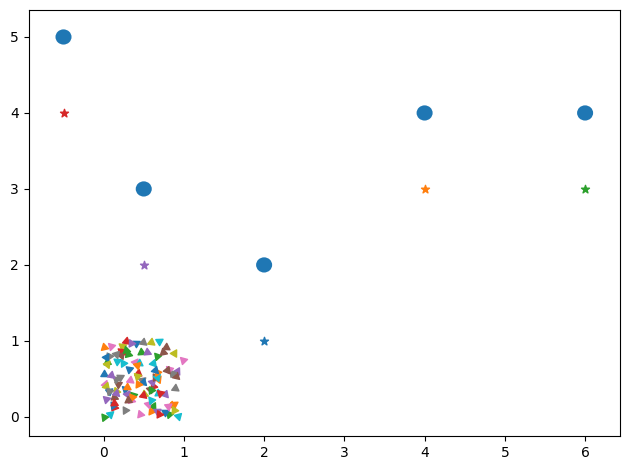

In [55]:
plt.figure()
positionsObstacle = [np.array([-.5, 5.]), np.array([.5, 3]), np.array([2.,2.]), np.array([4.,4.]), np.array([6.,4.])]
radiiObstacle = [0.1, 0.1, 0.1, 0.1, 0.1]
positionsAttractor = [np.array([-.5, 4.]), np.array([.5, 2]), np.array([2.,1.]), np.array([4.,3.]), np.array([6.,3.])]
radiiAttractor = [0.1, 0.1, 0.1, 0.1, 0.1]
obsset = obstacleset(positionsObstacle, radiiObstacle)
aset = attractorset(positionsAttractor, radiiAttractor)
F = flockset(100, [0, 1], [0, 1], 0.1, 1., obsset, 12)
fig = plotobstacleset(obsset)
plotattractorset(aset,fig)
plotflockset(F, fig)
plt.show()

<Figure size 640x480 with 0 Axes>

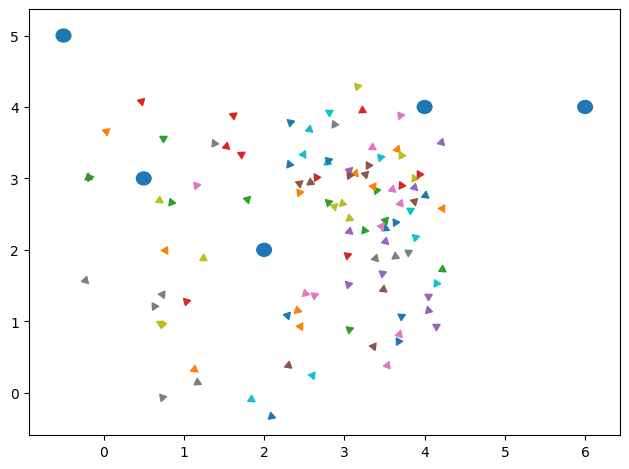

<Figure size 640x480 with 0 Axes>

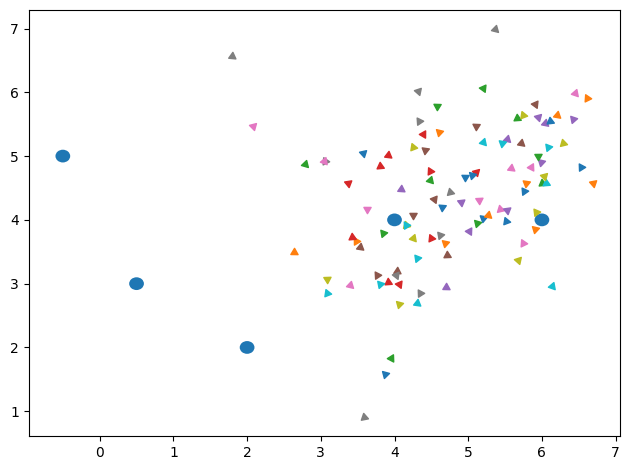

<Figure size 640x480 with 0 Axes>

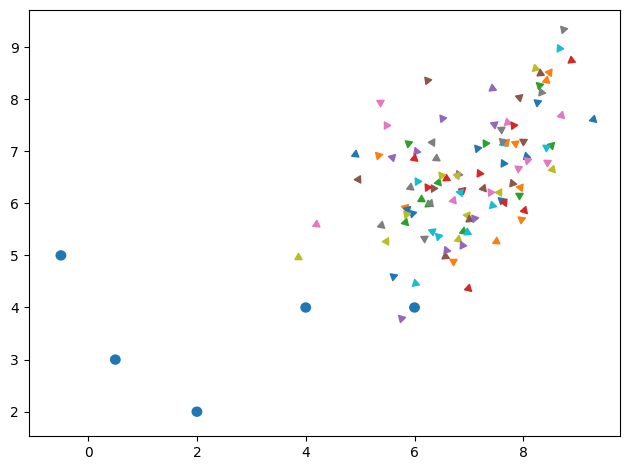

<Figure size 640x480 with 0 Axes>

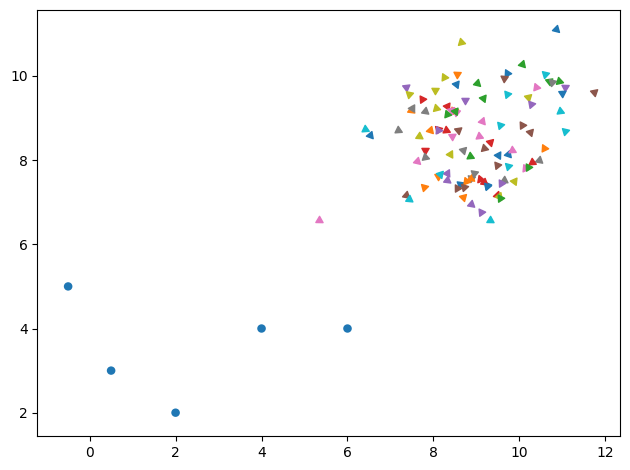

<Figure size 640x480 with 0 Axes>

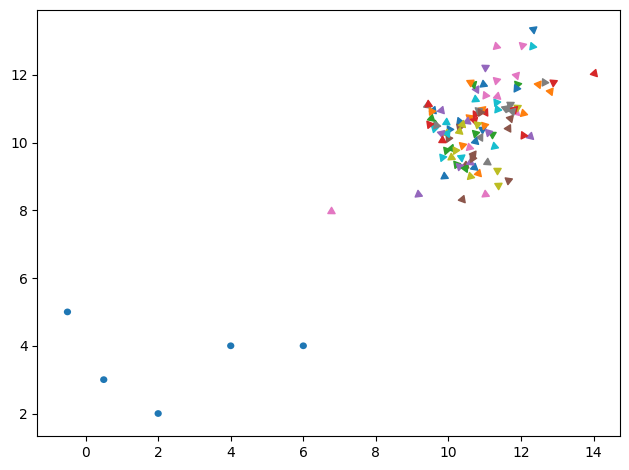

<Figure size 640x480 with 0 Axes>

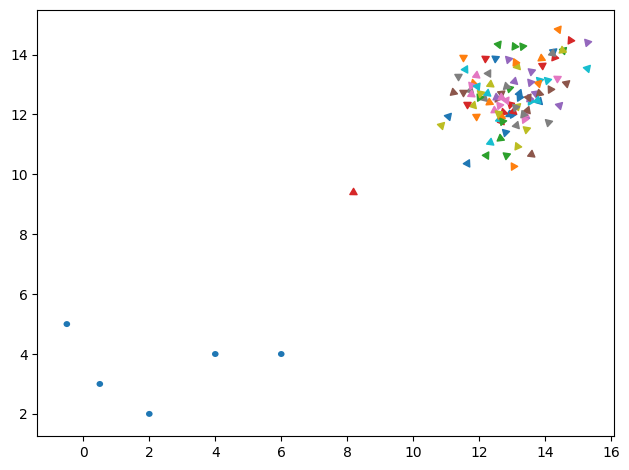

<Figure size 640x480 with 0 Axes>

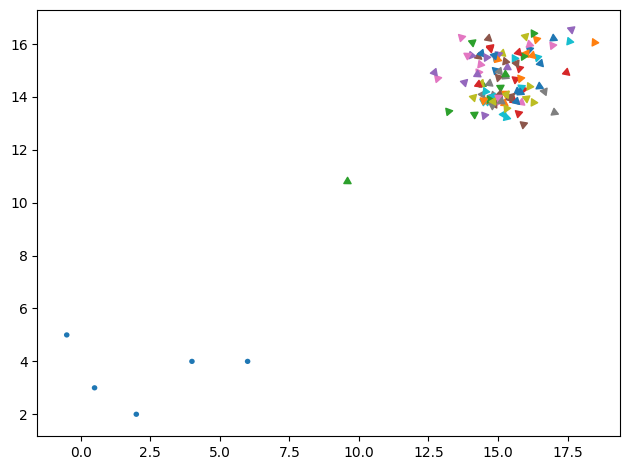

<Figure size 640x480 with 0 Axes>

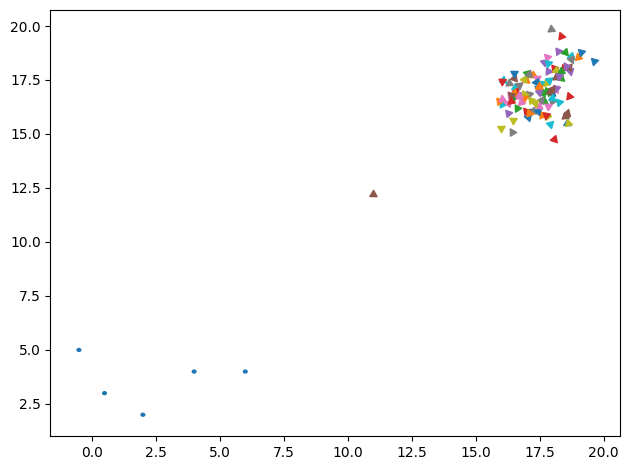

<Figure size 640x480 with 0 Axes>

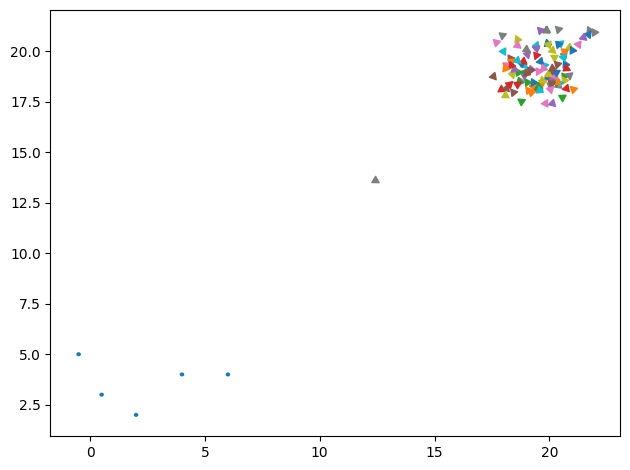

<Figure size 640x480 with 0 Axes>

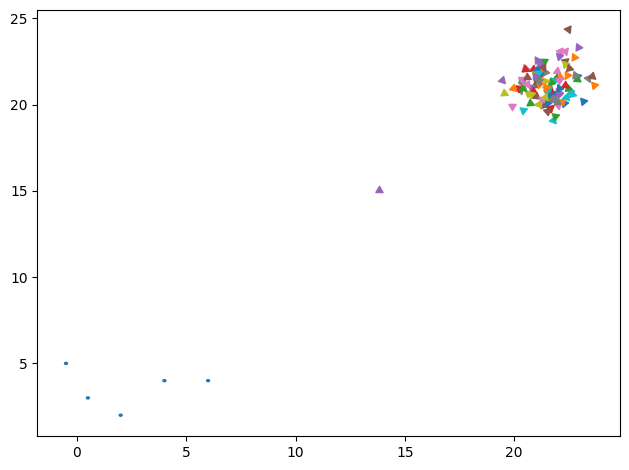

In [56]:
for ind in range(10):
    plt.figure()
    F = flock(F, obsset)
    fig = plotobstacleset(obsset)
    plotflockset(F, fig)
    fig.tight_layout()
    plt.show()